# Digit Recognizer with Pytorch
A simple approach with decent results. 

In [1]:
import numpy as np
import pandas as pd
import torch
from torch import nn, optim
import torchvision
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from collections import OrderedDict
import csv
import matplotlib.pyplot as plt

### Loading the data
Load the data by reading from the csv file.

In [2]:
#Loading data
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

### Getting the data ready for training
Split the training data into input data and labels. Then normalize the input data by dividing by 255 and it is ready to be converted to a tensor. 
Then split the training data into training and validation data and create the dataloaders. And of course load and normalize the test data and convert it to a tensor as well.

In [3]:
train_data = torch.tensor(df_train.drop(['label'], axis=1).values.astype('float32')) / 255
labels = torch.tensor(df_train['label'].values.astype(np.float32)).long()
test_data = torch.tensor(df_test.values.astype('float32')) / 255

In [4]:
#Getting dataloaders ready for training
train_tensor_dataset = torch.utils.data.TensorDataset(train_data, labels)

#Splitting the dataset into train and validate datasets
train_size = int(0.8 * len(train_tensor_dataset))
validate_size = len(train_tensor_dataset) - train_size
train_dataset, validate_dataset = torch.utils.data.random_split(train_tensor_dataset, [train_size, validate_size])

dataloaders = OrderedDict([
    ('train', torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)),
    ('validate', torch.utils.data.DataLoader(validate_dataset, batch_size=64, shuffle=True))
])

## An image representation of a batch of the data
Plotting 8x8 grid of images using matplotlib

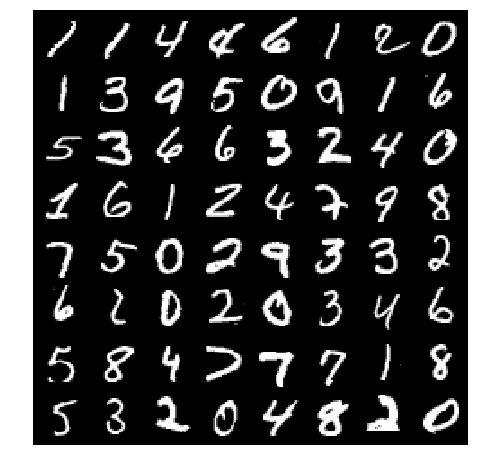

In [5]:
random_sel = np.random.randint(len(df_train), size=64)
grid = make_grid(torch.Tensor((df_train.iloc[random_sel, 1:].values/255.).reshape((-1, 28, 28))).unsqueeze(1), nrow=8)
plt.rcParams['figure.figsize'] = (64, 8)
plt.imshow(grid.numpy().transpose((1,2,0)))
plt.axis('off');

### Creating the model
Define a function that creates the model with input size, hidden layers, output size and dropout probability as parameters. 
The model has 2 hidden layers with ReLU as an activation function for the hidden layers and LogSoftmax for the output.

In [6]:
def create_model(input_size, hidden_layer=[4096, 2048], output_size=10, drop_p=0.5):
    model = nn.Sequential(OrderedDict([('layer1', nn.Linear(input_size, hidden_layer[0])),
                                            ('ReLU1', nn.ReLU()),
                                            ('layer2', nn.Linear(hidden_layer[0], hidden_layer[1])),
                                            ('ReLU2', nn.ReLU()),
                                            ('layer3', nn.Linear(hidden_layer[1], output_size)),
                                            ('dropout', nn.Dropout(p=drop_p)),
                                            ('output', nn.LogSoftmax(dim=-1))]))
    return model
model = create_model(train_data.shape[1], [200,100])

### Model validation
Define a function to validate the model with the validation chunk of the training data which was split earlier. 
The function takes the model, dataloader, device(cpu, cuda) and the criterion as parameters. 
The function returns the loss and the accuracy of the model with the validation data.

In [7]:
def validate_model(model, dataloader, device, criterion):
    correct = 0
    total = 0
    test_loss = 0
    model.to(device)
    model.float()
    for data in dataloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model.forward(inputs)
        test_loss += criterion(outputs, labels).item() / len(dataloader)
        ps = torch.exp(outputs)
        _, predicted = torch.max(ps.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        accuracy = 100 * correct / total
    return test_loss, accuracy

### Training the model
Define a function to train the model with the training data. 
The function takes the model, dataloader, learning rate, device(cpu, cuda) and epochs(number of iterations) as parameters. 
The function prints the loss and accuracy of the model with the training data and uses the validate_model function to print the loss and accuracy of the validation data with each iteration.

In [8]:
def train_network(model, dataloader, learning_rate=0.001, device='cuda', epochs=3):
    print_every = 100
    steps = 0
    model.to(device)
    criterion = nn.NLLLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    for e in range(epochs):
        model.train()
        running_loss = 0
        total = 0
        correct = 0
        for ii, (inputs, labels) in enumerate(dataloader):
            steps += 1
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            output = model.forward(inputs)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            # accuracy
            _, predicted = torch.max(output.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            if steps % print_every == 0:
                model.eval()
                with torch.no_grad():
                    test_loss, accuracy = validate_model(model, dataloaders['validate'], device, criterion)

                print("Epoch: {}/{}.. ".format(e+1, epochs),
                      "Training Loss: {:.3f}.. ".format(running_loss/print_every),
                      "Training Accuracy: %d %%" % (100 * correct / total),
                      "Test Loss: {:.3f}.. ".format(test_loss),
                      "Test Accuracy: %d %%" % (accuracy))

                running_loss = 0
        print('Finished Epoch!')
    print('Finished Training!')
train_network(model, dataloaders['train'], 0.001, 'cpu')

Epoch: 1/3..  Training Loss: 1.516..  Training Accuracy: 46 % Test Loss: 0.599..  Test Accuracy: 87 %
Epoch: 1/3..  Training Loss: 0.388..  Training Accuracy: 67 % Test Loss: 0.313..  Test Accuracy: 90 %
Epoch: 1/3..  Training Loss: 0.302..  Training Accuracy: 75 % Test Loss: 0.269..  Test Accuracy: 92 %
Epoch: 1/3..  Training Loss: 0.249..  Training Accuracy: 79 % Test Loss: 0.232..  Test Accuracy: 93 %
Epoch: 1/3..  Training Loss: 0.225..  Training Accuracy: 82 % Test Loss: 0.207..  Test Accuracy: 93 %
Finished Epoch!
Epoch: 2/3..  Training Loss: 0.756..  Training Accuracy: 57 % Test Loss: 0.228..  Test Accuracy: 93 %
Epoch: 2/3..  Training Loss: 0.171..  Training Accuracy: 78 % Test Loss: 0.171..  Test Accuracy: 94 %
Epoch: 2/3..  Training Loss: 0.154..  Training Accuracy: 84 % Test Loss: 0.166..  Test Accuracy: 95 %
Epoch: 2/3..  Training Loss: 0.142..  Training Accuracy: 87 % Test Loss: 0.157..  Test Accuracy: 95 %
Epoch: 2/3..  Training Loss: 0.152..  Training Accuracy: 89 % Test

### Saving results as a CSV
Run the model with the test data and get the top result and add it to the csv next to the imageId.

In [9]:
results = []
for inputs in test_data:
    with torch.no_grad():
        output = model.forward(torch.tensor(inputs))
        ps = torch.exp(output)
        results = np.append(results, ps.topk(1)[1].numpy()[0])
results = results.astype(int)
index = [x+1 for x in df_test.index.tolist()]
df = pd.DataFrame({'ImageId': index, 'Label':results})
df.to_csv("submission.csv", index = False)